In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

batch_size = 4

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = (0, 1, 2, 3, 4, 5, 6, 7 , 8, 9)

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


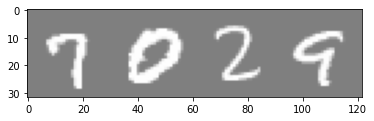

    7     0     2     9


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)


net = Net()

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/tmp/ipykernel_15464/3510950086.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


[1,  2000] loss: 1.564
[1,  4000] loss: 0.643
[1,  6000] loss: 0.482
[1,  8000] loss: 0.385
[1, 10000] loss: 0.366
[1, 12000] loss: 0.337
[1, 14000] loss: 0.303
[2,  2000] loss: 0.301
[2,  4000] loss: 0.282
[2,  6000] loss: 0.267
[2,  8000] loss: 0.257
[2, 10000] loss: 0.250
[2, 12000] loss: 0.237
[2, 14000] loss: 0.243
Finished Training


In [7]:
PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH)

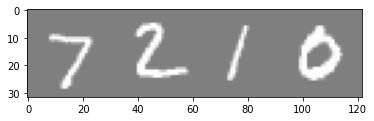

GroundTruth:      7     2     1     0


In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [9]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [10]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:      0     5     1     7


In [11]:
from torch.utils.tensorboard import SummaryWriter

# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

In [12]:
correct = 0
total = 0
all_images = list()
all_embeddings = list()
all_labels = list()

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_images.append(images)
        all_embeddings.append(outputs)
        all_labels.extend([classes[x.item()] for x in labels])
    
    all_images = torch.cat(all_images, 0)  
    all_embeddings = torch.cat(all_embeddings, 0)

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

/tmp/ipykernel_15464/3510950086.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Accuracy of the network on the 10000 test images: 93 %


In [13]:
writer.add_embedding(all_embeddings, metadata=all_labels, label_img=all_images)
writer.close()

In [ ]:
!tensorboard --logdir=runs --bind_all

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

TensorBoard 2.6.0 at http://d2e846083a37:6006/ (Press CTRL+C to quit)
